In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import MinMaxScaler

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2018_5min.nc')
ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)
ds

<xarray.Dataset> Size: 8GB
Dimensions:         (dt: 851534, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 7MB 2009-12-01 ... 2018-03-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 8GB ...
    BX_GSE          (dt) float64 7MB ...
    BY_GSE          (dt) float64 7MB ...
    BZ_GSE          (dt) float64 7MB ...
    flow_speed      (dt) int32 3MB ...
    proton_density  (dt) float64 7MB ...
    F10.7           (dt) int32 3MB ...
    Kp              (dt) int32 3MB ...
    doy             (dt) int32 3MB 335 335 335 335 335 335 ... 90 90 90 90 90 90
    doy_sin         (dt) float64 7MB -0.4938 -0.4938 -0.4938 ... 0.9998 0.9998
    doy_cos         (dt) float64 7MB 0.8696 0.8696 0.8696 ... 0.02152 0.02152

In [49]:
# Initialize scalers for the target variable and input variables
input_scaler = MinMaxScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'doy_sin','doy_cos']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 12
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)

X.shape, y.shape

((851522, 7, 12), (851522, 50, 24))

In [50]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.05):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio +test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((766369, 7, 12), (42576, 7, 12), (42577, 7, 12))

In [37]:
def random_time_series_split(X, y, segment_length, train_ratio=0.8, val_ratio=0.1):
    total_segments = len(X) // segment_length
    #total_samples = total_segments * segment_length
    
    # Shuffle indices to randomly select segments
    indices = np.arange(total_segments)
    np.random.shuffle(indices)
    
    # Calculate sizes of train, validation, and test sets
    train_size = int(total_segments * train_ratio)
    val_size = int(total_segments * val_ratio)
    #test_size = total_segments - train_size - val_size
    
    # Select indices for train, validation, and test sets
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Function to extract segments
    def extract_segments(indices):
        X_segments = []
        y_segments = []
        for idx in indices:
            start_idx = idx * segment_length
            X_segment = X[start_idx:start_idx + segment_length]
            y_segment = y[start_idx:start_idx + segment_length]
            X_segments.append(X_segment)
            y_segments.append(y_segment)
        return np.concatenate(X_segments), np.concatenate(y_segments)
    
    # Extract train, validation, and test sets
    X_train, y_train = extract_segments(train_indices)
    X_val, y_val = extract_segments(val_indices)
    X_test, y_test = extract_segments(test_indices)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

segment_length = 2016
#X_train, y_train, X_val, y_val, X_test, y_test = random_time_series_split(X, y, segment_length)
#X_train.shape, X_val.shape, X_test.shape

((681192, 7, 30), (85140, 7, 30), (85164, 7, 30))

In [51]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 50*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 50, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
model = LSTM(lookback, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1200, bias=True)
)

In [53]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=8, gamma=0.6)

In [54]:
# Train the model
num_epochs = 1
train_losses = []
val_losses = []

#early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        loss = loss_function(train_outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss += loss_function(val_outputs, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    #Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        #print(f'Counter is at {counter}')
        
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break
        else:
            continue

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}')

best_model = model
best_model.load_state_dict(torch.load('best_model.pt'))

Epoch [1/1], Loss (MAE): 0.0917, Val Loss (MAE): 0.1005


<All keys matched successfully>

### Make Predictions

In [55]:
predictions = best_model(X_test)
predictions = predictions.cpu().detach().numpy()

### Calulate Global Scores

In [56]:
RMSE = np.sqrt(np.mean((predictions - y_test.cpu().numpy())**2))
NRMSE = RMSE / (y_test.cpu().numpy().max() - y_test.cpu().numpy().min())
MAE = np.mean(np.abs(predictions - y_test.cpu().numpy()))
R = np.corrcoef(predictions.flatten(), y_test.cpu().numpy().flatten())[0, 1]

print(f'RMSE: {RMSE:.4f}, NRMSE: {NRMSE:.4f}, MAE: {MAE:.4f}, R: {R:.4f}')

RMSE: 0.1275, NRMSE: 0.0153, MAE: 0.0824, R: 0.2532


### Daily Predictions

In [59]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)
    ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
    ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

<xarray.Dataset> Size: 7MB
Dimensions:         (dt: 707, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 6kB 2013-05-14 ... 2013-05-14T23:58:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables: (12/15)
    jPar            (dt, mlat, mlt) float64 7MB dask.array<chunksize=(707, 50, 24), meta=np.ndarray>
    BX_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    BY_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    BZ_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    flow_speed      (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>
    proton_density  (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    ...              ...
    ASY_H           (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    F10.7           (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>
    Kp              (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    doy             (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>
    doy_sin         (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    doy_cos         (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>

In [60]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    doy_sin = ds['doy_sin'].values.flatten() #6
    doy_cos = ds['doy_cos'].values.flatten() #7
    
    #AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    #AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    #SYM_H = ds['SYM_H'].values.flatten() #8
    #ASY_H = ds['ASY_H'].values.flatten()  #9
    #F10_7 = ds['F10.7'].values.flatten() #10
    #Kp = ds['Kp'].values.flatten() #11

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density, 'doy_sin': doy_sin, 'doy_cos': doy_cos}
    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [63]:
norm_arr = input_scaler.transform(df_proc)

def create_sequences(arr, lookback=lookback):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(norm_arr)
raw_seq = create_sequences(df_raw.values)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [64]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

# Adjust the shape to match the model's expected input size
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)
norm_proc = norm_proc.permute(0, 1, 2)  # Change from [848370, 11, 30] to [848370, 30, 11]

predictions = []

with torch.no_grad():
    for i in range(len(norm_proc)):
        output = best_model(norm_proc[i].unsqueeze(0))
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.numpy()  # Tensor is already on CPU, no need to move again

array([[[-9.63652506e-04, -4.90243733e-03, -6.19364623e-03, ...,
         -7.78706186e-03,  1.85114928e-02,  2.47823130e-02],
        [ 3.09788994e-02,  2.79124863e-02,  1.81795508e-02, ...,
          8.33858177e-03,  1.30957700e-02,  6.74995407e-03],
        [ 6.04663417e-03,  6.64976658e-03, -5.81302820e-03, ...,
         -6.94828629e-02, -5.33318967e-02, -1.26527026e-02],
        ...,
        [-3.60056758e-04, -2.02985853e-03,  2.93672085e-04, ...,
          8.44150782e-05, -5.80395386e-03, -1.49971992e-03],
        [-6.46303222e-03, -2.00820975e-02, -2.49340348e-02, ...,
         -6.54703379e-03, -1.87621638e-03,  9.88782570e-03],
        [ 1.53666101e-02,  5.03794104e-03, -4.05007973e-03, ...,
          7.18172640e-03,  6.12414815e-03,  7.41491653e-03]],

       [[-9.35629010e-04, -4.91032004e-03, -6.18409924e-03, ...,
         -7.78632611e-03,  1.85162574e-02,  2.47331131e-02],
        [ 3.09585966e-02,  2.79109441e-02,  1.81865543e-02, ...,
          8.33082199e-03,  1.31581835e

In [66]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values[lookback:])},
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds

<xarray.Dataset> Size: 10MB
Dimensions:    (dt: 695, mlat: 50, mlt: 24)
Coordinates:
  * dt         (dt) datetime64[ns] 6kB 2013-05-14T00:24:00 ... 2013-05-14T23:...
  * mlat       (mlat) int64 400B 40 41 42 43 44 45 46 ... 83 84 85 86 87 88 89
  * mlt        (mlt) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred  (dt, mlat, mlt) float32 3MB -0.0009637 -0.004902 ... 0.007478
    Jpar_true  (dt, mlat, mlt) float64 7MB -0.295 -0.2074 ... -0.007801 -0.05974

In [80]:
timestep = 167

R = np.corrcoef(ds['Jpar_pred'].isel(dt=timestep).values, ds['Jpar_true'].isel(dt=timestep).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=timestep).values) - np.min(ds['Jpar_true'].isel(dt=timestep).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')

R: 0.369, RMSE: 0.100, NRMSE: 0.080, MAE: 0.072


<>:38: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_66249/4100711663.py:38: SyntaxWarning: invalid escape sequence '\p'
  plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12,


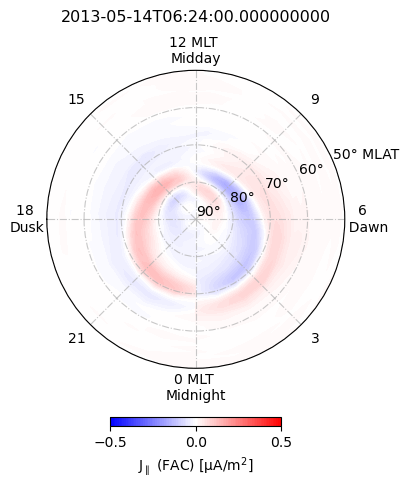

In [81]:
fac = ds['Jpar_pred'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-0.5,.5 , 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0,  0.5], 
             orientation='horizontal')

plt.tight_layout()